# Résolution numérique de l'équation de transport

Comme pour l'équation de la chaleur, nous allons comparer différentes méthodes de résolution du problème suivant:
$$ 
\begin{equation}
    \left\{
        \begin{aligned}
            u_t + cu_x = 0 & \quad \forall (x,t) \in ]0, L[\times]0, T[ \\
            u(0, t) = u(L, t) = 0 & \quad \forall t \in ]0, T[ \\
            u(x, 0) = u_0(x) & \quad \forall x \in ]0, L[
        \end{aligned}
    \right.
\end{equation}
$$
pour $c>0$, $L>0$ et $T>0$ fixés.

Pour l'application, nous considérons que:
- $c=L=1$ et $T=0.5$
- la condition initiale est $u_0(x) = exp(-200(x - \frac{1}{4})^2)$

## 1) Solution analytique
### Méthode des caractéristiques

La solution exacte est donc $u(x,t) = u_0(x - ct) = exp(-200(x - ct - \frac{1}{4})^2)$

### Tracés de la solution

In [1]:
import numpy as np
import numpy.linalg as npl

import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt 
import math

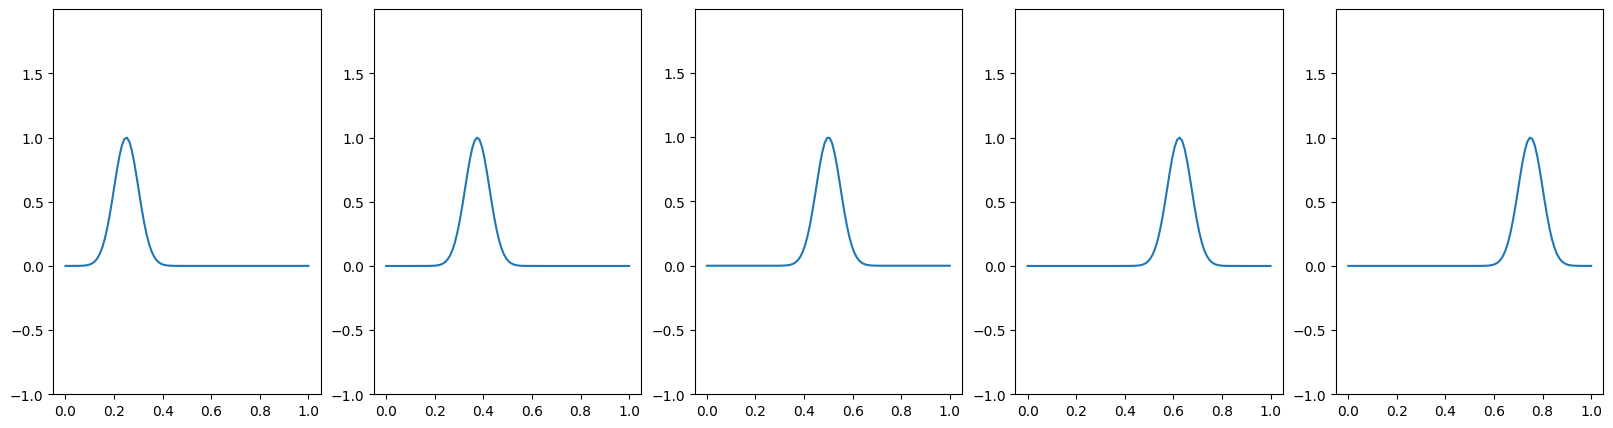

In [73]:
C = 0.01 # Nombre CFL, voir 2.a Stabilité du schéma décentré

# Paramètres
c = 1
L = 1
T = 0.5

N = 100
M = N / (2 * C) # Respect de la condition CFL, voir 2) Schéma explicite décentré


x = np.linspace(0, L, N) # Maillage spatial
deltaX = L / N 
deltaT = T / M
valT = [k / 4 * T for k in range(0, 5)] # Valeurs de temps observés à l'affichage

def y_exact(t):
    return np.exp(-200 * (x - c * t - 0.25) ** 2)

def affAnalytique():
    fig, ax = plt.subplots(1, len(valT), figsize = (20, 5))
    x = np.linspace(0, L, N)
    for i, t in enumerate(valT):
        y = y_exact(t)
        ax[i].set_ylim(min(y) - 1, max(y) + 1)
        ax[i].plot(x, y)

affAnalytique()

## 2) Schéma décentré

Par le développement de Taylor au premier ordre, on obtient:
$$ 
\begin{equation} \notag
    \left\{
        \begin{aligned}
            u(x + \Delta x, t) &=& u(x, t) + \Delta xu_x(x, t) &\Longleftrightarrow& u_x(x, t) = \frac{u(x + \Delta x, t) - u(x, t)}{\Delta x}\\
            u(x, t + \Delta t) &=& u(x, t) + \Delta tu_t(x, t) &\Longleftrightarrow& u_t(x, t) = \frac{u(x, t + \Delta t) - u(x, t)}{\Delta t}\\
        \end{aligned}
    \right.
\end{equation}
$$
On note $x_0 < ... < x_N$ et $t_0 < ... < t_M$ pour $(N,M) \in \mathbb{N}^2$ les maillages spatial et temporel, avec:
$$
\begin{equation} \notag
    \begin{aligned}
        x_0 = t_0 = 0 \quad & \quad x_n = n\Delta x \\
        x_N = L \quad & \quad t_m = m\Delta t \\
        t_M = T \quad & \quad u_n ^m = u(x_n, t_m) \\
    \end{aligned}
\end{equation}
$$
Ainsi, nous obtenons
$$ 
\begin{equation} \notag
    \left\{
        \begin{aligned}
            u_x(x, t) = \frac{u_{n}^{m} - u_{n-1}^m}{\Delta x}\\
            u_t(x, t) = \frac{u_{n}^{m+1} - u_{n}^m}{\Delta t}\\
        \end{aligned}
    \right.
\end{equation}
$$
Avec l'équation de transport, nous avons donc
$$ 
\begin{aligned}
    & 0 = u_t + cu_x = \frac{1}{\Delta t}(u_{n}^{m+1} - u_{n}^m) + \frac{c}{\Delta x}(u_{n}^m - u_{n-1}^m) \\
    \Longleftrightarrow \quad & u_{n}^{m+1} = u_{n}^m - \beta(u_{n}^m - u_{n-1}^m) \quad \text{avec} \quad \beta = c\frac{\Delta t}{\Delta x}
\end{aligned}
$$

Le schéma décentré s'écrit donc
$$ U^{m+1} = (I_N - \beta A)U^m $$
avec
$$
U^m = 
\left(
    \begin{array}{ccc}
        u_0 ^m \\
        \vdots \\
        u_n ^m \\
    \end{array}
\right)
\quad \text{et} \quad
A =
\left(
    \begin{array}{ccc}
        1 &&&& \\
        -1 & 1 &&& \\
        & \ddots & \ddots && \\
        && -1 & 1 & \\
        &&& -1 & 1 \\
    \end{array}
\right)
$$

### a) Stabilité du schéma

Nous allons montrer que sous la condition CFL (c'est à dire $\beta \leq 1$), le schéma est stable dans $L^2$ et dans $L^{\infty}$.

Notons $P = I_N - \beta A$. Le schéma s'écrit alors $U^m = P^mU_0$.
Pour vérifier la stabilité, montrons qu'il existe $C>0$ tel que pour tout $U_0 ^0, U_1 ^1$ dans $\mathbb{R}^N$ et pour tout $m\in \mathbb{N}$, on a
$$ \lVert U_0 ^m - U_1 ^m\rVert < C\lVert U_0 ^0 - U_0 ^1\rVert$$

Soient $U_0 ^0, U_1 ^1$ dans $\mathbb{R}^N$ et pour tout $m\in \mathbb{N}$.

Ainsi $U_0 ^m - U_1 ^m = A^m(U_0 ^0 - U_1 ^0)$, donc si $\lVert A\rVert < 1 $, alors $ \lVert U_0 ^m - U_1 ^m\rVert < \lVert A\rVert ^m \lVert U_0 ^m - U_1 ^m\rVert < \lVert U_0 ^m - U_1 ^m\rVert$.

#### i) Norme $L^2$

Dans cette partie, la norme $\lVert \cdot \rVert$ est la norme euclidienne.

Soit $u\in\mathbb{R}^N$ de norme 1. Ainsi, on a 
$$
\begin{aligned}
    \lVert Pu \rVert ^2 &= (1 - \beta)^2u_1 ^2 + \sum_{k = 2}^N(\beta u_{k-1} + (1 - \beta)u_k)^2 \\
    &= (1 - \beta)^2u_1 ^2 + (1 - \beta)^2\sum_{k = 2}^N u_k ^2 + 2\beta(1 - \beta)\sum_{k = 2}^Nu_{k-1}u_k + \beta^2\sum_{k = 2}^N u_{k-1}^2
\end{aligned}
$$

On pose $v_1 = \left( \begin{array}{ccc} 0 \\ u_2 \\ \vdots \\ u_N \end{array} \right)$ et $v_2 = \left( \begin{array}{ccc} 0 \\ u_1 \\ \vdots \\ u_{N-1} \end{array} \right)$. Ainsi, on a $\lVert v_1 \rVert \leq \lVert u \rVert \leq 1$, et de même pour $v_2$.

Par l'inégalité de Cauchy-Schwartz, on $\sum_{k = 2}^Nu_{k-1}u_k = \langle v_1, v_2 \rangle \leq \lVert v_1 \rVert \lVert v_2 \rVert \leq 1 $.
De plus, 
$$ 
\sum_{k = 2}^N u_{k-1}^2 \leq \lVert u \rVert = 1 \quad \text{et} \quad (1 - \beta)^2u_1 ^2 + (1 - \beta)^2\sum_{k = 2}^Nu_k ^2 = (1 - \beta)^2\sum_{k = 1}^Nu_k ^2 = (1 - \beta) ^2
$$

Finalement, on a $\lVert Pu \rVert ^2 \leq (1 - \beta)^2 + 2\beta(1 - \beta) + \beta ^2 = 1$
et donc $\lVert P \rVert = {max}_{u\in\mathbb{R}^N, \lVert u \rVert = 1} \lVert Pu \rVert \leq 1$.
Pour $C = 1$, le schéma est stable dans $L^2$.

#### ii) Norme $L^{\infty}$
Dans cette partie, la norme $\lVert \cdot \rVert$ est la norme infinie définie par $\lVert u \rVert = max_{1\leq k \leq N} \lvert u_k \rvert $, pour $u = \left( \begin{array}{ccc} u_1 \\ \vdots \\ u_N \end{array} \right) \in \mathbb{R}^N$.

Comme $0<\beta\leq 1$, les coefficients de la patrice $P$ sont tous positifs et le maximum est atteint pour $u = \left( \begin{array}{ccc} 1 \\ \vdots \\ 1 \end{array} \right) \in\mathbb{R}^N$. 

On a $Pu = \left( \begin{array}{ccc} 1 - \beta \\ 1 \\ \vdots \\ 1 \end{array} \right)$ et comme $\beta \leq 1$, on a $1 - \beta \leq 1$,
et finalement,
$\lVert Pu \rVert = \lvert \beta + 1 - \beta \rvert = 1$.

Donc pour $C = 1$, le schéma est stable dans $L^{\infty}$.

### b) Implémentation

On rappelle que le schéma décentré s'écrit
$$ U^{m+1} = (I_N - \beta A)U^m $$
avec
$$
U^m = 
\left(
    \begin{array}{ccc}
        u_0 ^m \\
        \vdots \\
        u_n ^m \\
    \end{array}
\right)
\quad \text{et} \quad
A =
\left(
    \begin{array}{ccc}
        1 &&&& \\
        -1 & 1 &&& \\
        & \ddots & \ddots && \\
        && -1 & 1 & \\
        &&& -1 & 1 \\
    \end{array}
\right)
$$


In [55]:
# Implémentation de U0, beta et A
U0 = y_exact(0)
beta = c * deltaT / deltaX
A = sps.eye(N, format = 'csc') - sps.eye(N, k = -1, format = 'csc')

# Calcul du U(t)
def Udec(t):
    Um = U0
    for m in range(int(t / deltaT)):
        Um = (sps.eye(N, format = 'csc') - beta * A).dot(Um)
    return Um


### c) Tracés

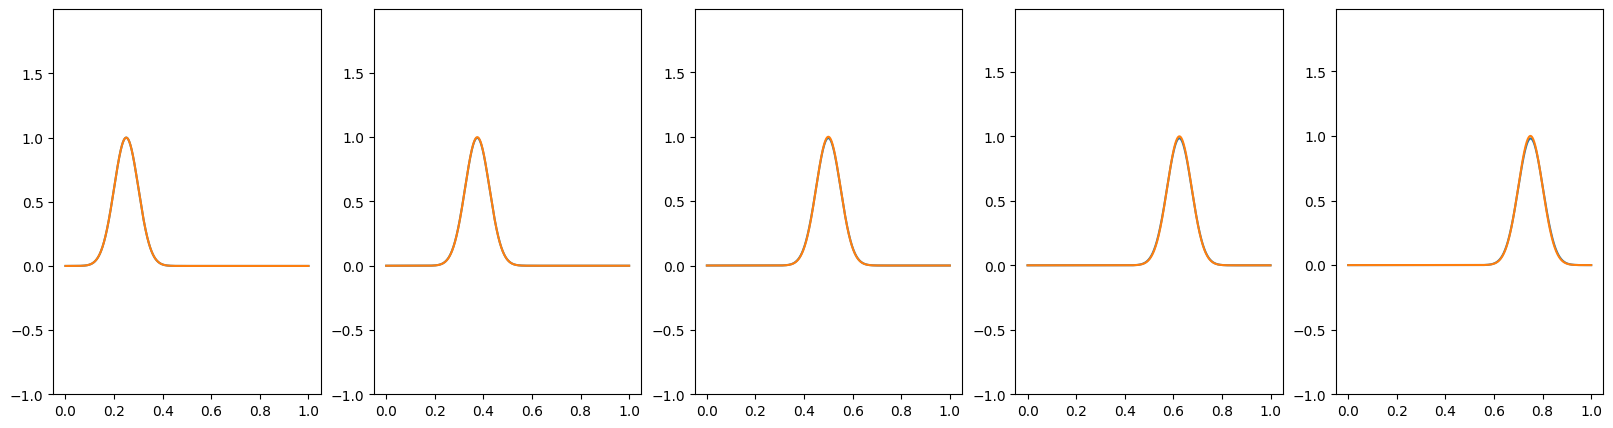

In [56]:
def affExp():
    fig, ax = plt.subplots(1, len(valT), figsize = (20, 5))

    for i, t in enumerate(valT):
        y = Udec(t)
        ax[i].set_ylim(min(y) - 1, max(y) + 1)
        ax[i].plot(x, y)
        ax[i].plot(x, y_exact(t))

affExp()

### d) Convergence du schéma
Nous vérifierons en norme $L^1$ et $L^2$ la convergence du schéma.

In [47]:
def normeLp(x1, x2, p = 2):
    return sum(np.absolute(x1 - x2) ** p) ** (1 / p)

print('Distance en norme 1:')
for t in valT:
    print('     t = ', t, ': ', np.round(normeLp(y_exact(t), Udec(t), 1), 4))
    
print('\nDistance en norme 2:')
for t in valT:
    print('     t = ', t, ': ', np.round(normeLp(y_exact(t), Udec(t), 2), 4))

Distance en norme 1:
     t =  0.0 :  0.0
     t =  0.125 :  0.6161
     t =  0.25 :  1.2262
     t =  0.375 :  1.8305
     t =  0.5 :  2.5354

Distance en norme 2:
     t =  0.0 :  0.0
     t =  0.125 :  0.0417
     t =  0.25 :  0.0828
     t =  0.375 :  0.1235
     t =  0.5 :  0.1726


## Schéma centré

En reprenant le développement de Taylor vu précedemment, on obtient:
$$ 
\begin{aligned}
    u_x(x, t) &= \frac{1}{2}(u_x(x, t) + u_x(x, t)) \\
                &= \frac{1}{2} (\frac{u(x + \Delta x, t) - u(x, t)}{\Delta x} + \frac{u(x, t) - u(x - \Delta x, t)}{\Delta x}) \\
                &= \frac{1}{2} (\frac{u(x + \Delta x, t) - u(x - \Delta x, t)}{\Delta x}) \\
\end{aligned}
$$

L'équation de transport devient donc:
$$ 
\begin{aligned}
    & 0 = u_t + cu_x = \frac{1}{\Delta t}(u_{n}^{m+1} - u_{n}^m) + \frac{c}{2\Delta x}(u_{n+1}^m - u_{n-1}^m) \\
    \Longleftrightarrow \quad & u_{n}^{m+1} = u_{n}^m - \frac{\beta}{2}(u_{n+1}^m - u_{n-1}^m) 
\end{aligned}
$$

Le schéma centré s'écrit donc
$$ U^{m+1} = (I_N - \frac{\beta}{2} A_c)U^m
\quad \text{avec} \quad
A_c =
\left(
    \begin{array}{ccc}
        0 & 1 &&& \\
        -1 & 0 & 1 && \\
        & \ddots & \ddots & \ddots & \\
        && -1 & 0 & 1 \\
        &&& -1 & 1 \\
    \end{array}
\right)
$$

### a) Implémentation

In [70]:
# Implémentation de U0, beta et A
U0 = y_exact(0)
beta = c * deltaT / deltaX
Ac = sps.eye(N, k = 1, format = 'csc') - sps.eye(N, k = -1, format = 'csc')
Ac[N - 1, N - 1] = 1

# Calcul du U(t)
def Ucen(t):
    Um = U0
    for m in range(int(t / deltaT)):
        Um = (sps.eye(N, format = 'csc') - beta * Ac / 2).dot(Um)
    return Um


### b) Tracés

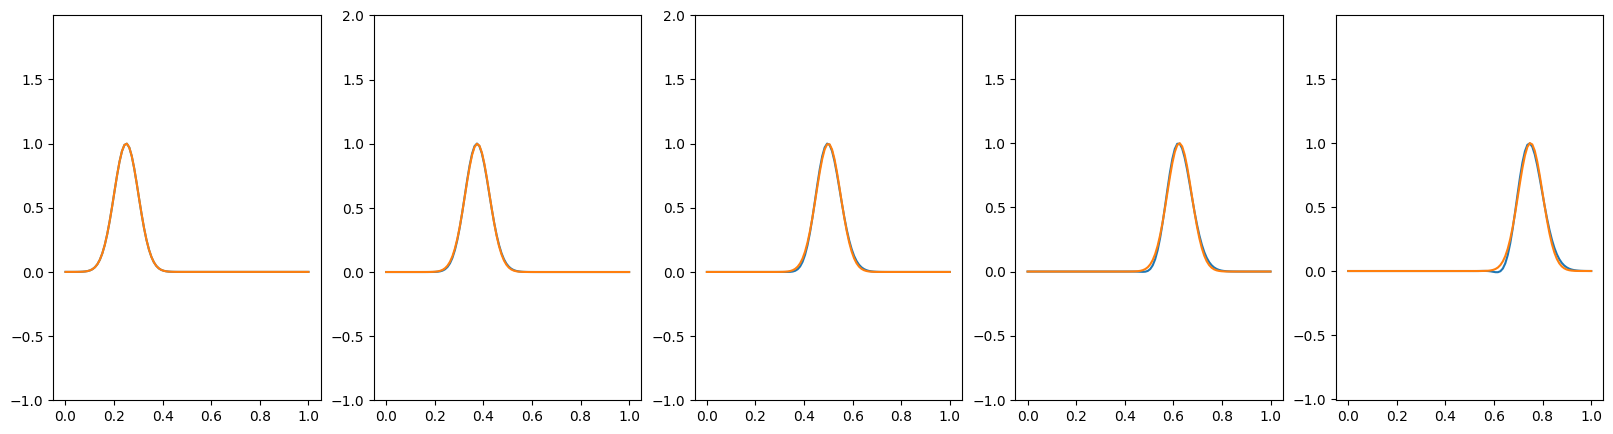

In [71]:
def affExp():
    fig, ax = plt.subplots(1, len(valT), figsize = (20, 5))

    for i, t in enumerate(valT):
        y = Ucen(t)
        ax[i].set_ylim(min(y) - 1, max(y) + 1)
        ax[i].plot(x, y)
        ax[i].plot(x, y_exact(t))

affExp()

### c) Convergence du schéma
Nous vérifierons en norme $L^1$ et $L^2$ la convergence du schéma.

In [72]:
def normeLp(x1, x2, p = 2):
    return sum(np.absolute(x1 - x2) ** p) ** (1 / p)

print('Distance en norme 1:')
for t in valT:
    print('     t = ', t, ': ', np.round(normeLp(y_exact(t), Ucen(t), 1), 4))
    
print('\nDistance en norme 2:')
for t in valT:
    print('     t = ', t, ': ', np.round(normeLp(y_exact(t), Ucen(t), 2), 4))

Distance en norme 1:
     t =  0.0 :  0.0
     t =  0.125 :  0.2352
     t =  0.25 :  0.4703
     t =  0.375 :  0.7015
     t =  0.5 :  0.9237

Distance en norme 2:
     t =  0.0 :  0.0
     t =  0.125 :  0.0442
     t =  0.25 :  0.0886
     t =  0.375 :  0.133
     t =  0.5 :  0.177
